# Deep Learning Solution for Recyclable vs Non-Recyclable Waste Classification

**Group 7**<br>

**Group Members:** 

Jennifer Agu -8882641<br> Emmanuel Obiekwe - 8877022<br>

**Course code:** CSCN 8010- Foundations of Machine Learning Frameworks <br>

**Date:** 17TH APRIL 2025

## **Executive Summary**

**Problem Statement:** The improper sorting of recyclable items from non-recyclable waste creates both economic and environmental problems. Manual waste sorting proves inefficient and time-consuming and produces many human errors. The objective of this project involves developing a model which applies deep learning principles to categorize recyclable items against non recyclable items. The solution aims to help recycling facilities, governments, and individuals improve waste management practices by precisely classifying waste products. This will reduce landfill overflow, promote sustainability, and increase recycling efficiency.

**Real-world relevance:** In the real world, growing environmental restrictions and landfill limitations are driving cities and businesses to actively seek out more intelligent waste management solutions.  Although AI-powered sorting systems, like those employed by AMP Robotics and other organizations, are already having an impact, but more reasonably priced, scalable versions are still desperately needed.  Accurate recycling might be made available to consumers and businesses alike by using a deep learning-based solution in recycling facilities, smart bins, or smartphone apps.  The project supports international initiatives to reduce carbon emissions and create a circular economy.


**Import the required python libraries**

In [2]:
import os
import math
import shutil
import random
import pathlib
import numpy as np
import seaborn as sns
from PIL import Image  
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2, ResNet152
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

## **Dataset Description and Preparation**

### **Dataset source**<br>
Kaggle dataset : https://www.kaggle.com/datasets/quangtheng/garbage-classification-6-classes-775class

### **Load the Dataset**
**We will be loading the dataset and confirming the number of classes and total images**

In [4]:
# Create the path to the dataset folder
dataset_path = "C:/Users/aceadmin/Downloads/archive4"  

# This is to get the list of class folders inside the dataset folder
class_folders = os.listdir(dataset_path)

# Initialize a counter for the total number of images
total_images = 0

# Initialize a list to store all image resolution
image_resolutions = []

# This will loop through each class folder to count images and store their resolutions
print("Number of images in each class:")
for folder in class_folders:
    # This will create the full path to the class folder
    folder_path = os.path.join(dataset_path, folder)

    # This is to check the folder 
    if os.path.isdir(folder_path):
        # This will get all files inside the class folder
        image_files = os.listdir(folder_path)

        # Initialize a counter for each class
        image_count = 0

        # Loop through all files in the class folder
        for file in image_files:
            # This will get the full path to the image file
            image_path = os.path.join(folder_path, file)
            try:
                # Open the image
                with Image.open(image_path) as img:
                    image_count += 1 
                    image_resolutions.append(img.size)  # Append the image resolution
            except:
                pass

        # Increment the count
        total_images += image_count

        # Display how many images were in this class
        print(f"Class '{folder}': {image_count} images")

# Display the total number of classes and total number of images
print("\nTotal number of classes:", len(class_folders))
print("Total number of images:", total_images)

Number of images in each class:
Class 'battery': 775 images
Class 'glass': 775 images
Class 'metal': 775 images
Class 'organic': 775 images
Class 'paper': 775 images
Class 'plastic': 775 images

Total number of classes: 6
Total number of images: 4650


### **Image Resolution**
**We will be checking the top 10 most common Image resolution**

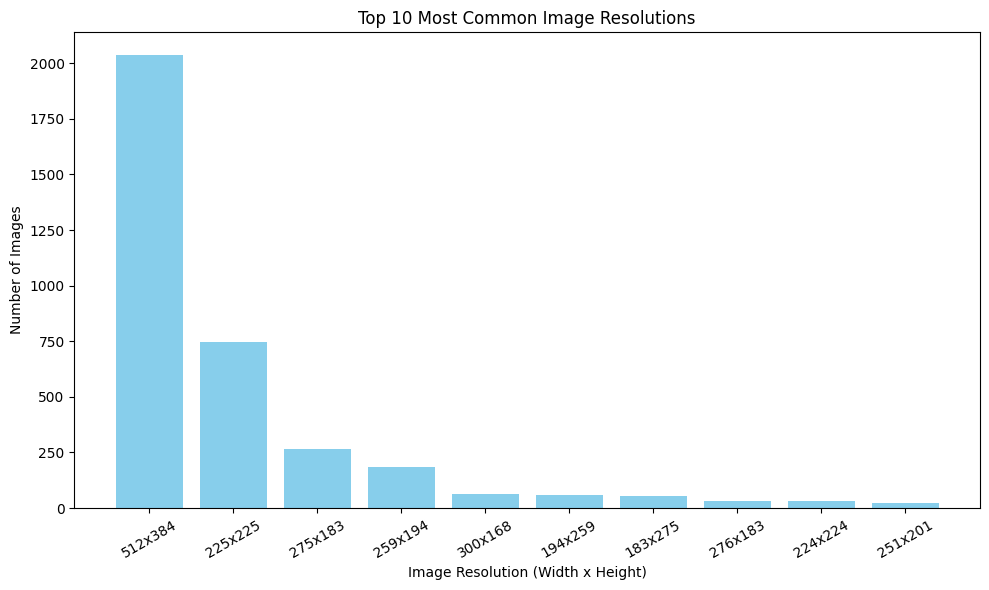

In [5]:
# Count image resolutions
resolution_counts = Counter(image_resolutions)

# Get the top 10 most common resolutions
top_resolutions = resolution_counts.most_common(10)

# Plot to show the top 10 most common resolution
resolution_labels = [f"{w}x{h}" for (w, h), _ in top_resolutions]
counts = [count for _, count in top_resolutions]

# Barplot
plt.figure(figsize=(10, 6))
plt.bar(resolution_labels, counts, color='skyblue')
plt.title("Top 10 Most Common Image Resolutions")
plt.xlabel("Image Resolution (Width x Height)")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### **Organizing the dataset**
**We will be organizing the dataset into recyclable and non recyclable**

In [4]:
# Get the folder paths
source_dir = Path("C:/Users/aceadmin/Downloads/archive4") 

# Create a new folder
dest_dir = Path("C:/Users/aceadmin/Downloads/archive4_binary")  

# Define recyclable and non-recyclable groups
recyclable = ['plastic', 'metal', 'paper', 'glass']
non_recyclable = ['battery', 'organic']

# Create folders to store the recyclable and non recyclable
(dest_dir / "recyclable").mkdir(parents=True, exist_ok=True)
(dest_dir / "non_recyclable").mkdir(parents=True, exist_ok=True)

# Move files into their new folders(recyclable and non recyclable)
for category in recyclable + non_recyclable:
    source_folder = source_dir/ category
    if not source_folder.exists():
        print(f"Folder {category} not found, skipping...")
        continue

    # Pick where to copy the images to
    target_group = "recyclable" if category in recyclable else "non_recyclable"
    target_folder = dest_dir / target_group

    # copy the images to the required folder
    for image_file in source_folder.glob("*.*"):
        if image_file.is_file():
            shutil.copy2(image_file, target_folder / image_file.name)


### **Split the dataset**
**We will be splitting the dataset into train, validation and test**

In [5]:
# Folder where your grouped images now live
original_dir = pathlib.Path("C:/Users/aceadmin/Downloads/archive4_binary")
new_base_dir = pathlib.Path("C:/Users/aceadmin/Downloads/archive4_binary_split")

# Subset function for recyclable and non-recyclable
def make_subset(subset_name, start_index, end_index):
    for category in ("recyclable", "non_recyclable"):
        src_folder = original_dir / category
        dst_folder = new_base_dir / subset_name / category
        os.makedirs(dst_folder, exist_ok=True)

        # Get all files from source category folder
        all_images = sorted([f for f in src_folder.iterdir() if f.is_file()])
        subset_images = all_images[start_index:end_index]

        # Copy subset images to target subset folder
        for image_path in subset_images:
            shutil.copyfile(image_path, dst_folder / image_path.name)

# Split the binary dataset into train, validation, and test
make_subset("train", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=650)
make_subset("test", start_index=650, end_index=775)

In [6]:
# Load the train dataset fron the new_base_dir/train folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
train_dataset = image_dataset_from_directory(new_base_dir/ "train", image_size=(180, 180), batch_size=32)

# Load the validation dataset fron the new_base_dir/validation folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)

# Load the test dataset fron the new_base_dir/test folder path, resize the image to a 180 x 180 pixels and then group them in a batch size of 32
test_dataset = image_dataset_from_directory( new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 1000 files belonging to 2 classes.
Found 300 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


### **Convert test dataset to NumPy arrays**

In [7]:
# Convert test dataset to NumPy arrays
test_images_list = []
test_labels_list = []

for images, labels in test_dataset:  
    test_images_list.append(images.numpy())
    test_labels_list.append(labels.numpy())

test_images = np.concatenate(test_images_list)
test_labels = np.concatenate(test_labels_list)

## **Exploratory Data Analysis (EDA)**

### **Display the Data and labels batch shape for train, validation and test dataset**

In [11]:
print('Train Data:')
for data_batch, labels_batch in train_dataset:
    print("data batch shape for the train data:", data_batch.shape)
    print("labels batch shape for the train data:", labels_batch.shape)
    break

print('\nValidation Data:')
for data_batch, labels_batch in validation_dataset:
    print("data batch shape for the Validation Data :", data_batch.shape)
    print("labels batch shape for the Validation Data:", labels_batch.shape)
    break 

print('\nTest Data:')
for data_batch, labels_batch in test_dataset:
    print("data batch shape for the test Data:", data_batch.shape)
    print("labels batch shape for the test Data:", labels_batch.shape)
    break


Train Data:
data batch shape for the train data: (32, 180, 180, 3)
labels batch shape for the train data: (32,)

Validation Data:
data batch shape for the Validation Data : (32, 180, 180, 3)
labels batch shape for the Validation Data: (32,)

Test Data:
data batch shape for the test Data: (32, 180, 180, 3)
labels batch shape for the test Data: (32,)


**Explain:**
This shows that the train, validation and test dataset have a data batch size of (32, 180, 180, 3) which means the each batch have 32 images, 180 by 180 pixels size and the 3 which is the number of channels that is the image color are Red, Green, and Blue (RGB). Also the labels shape of 32 indicates one for each of the image in the batch which are 0 and 1 depending on whether its cat or dog.

### **Display Random images from the train dataset**

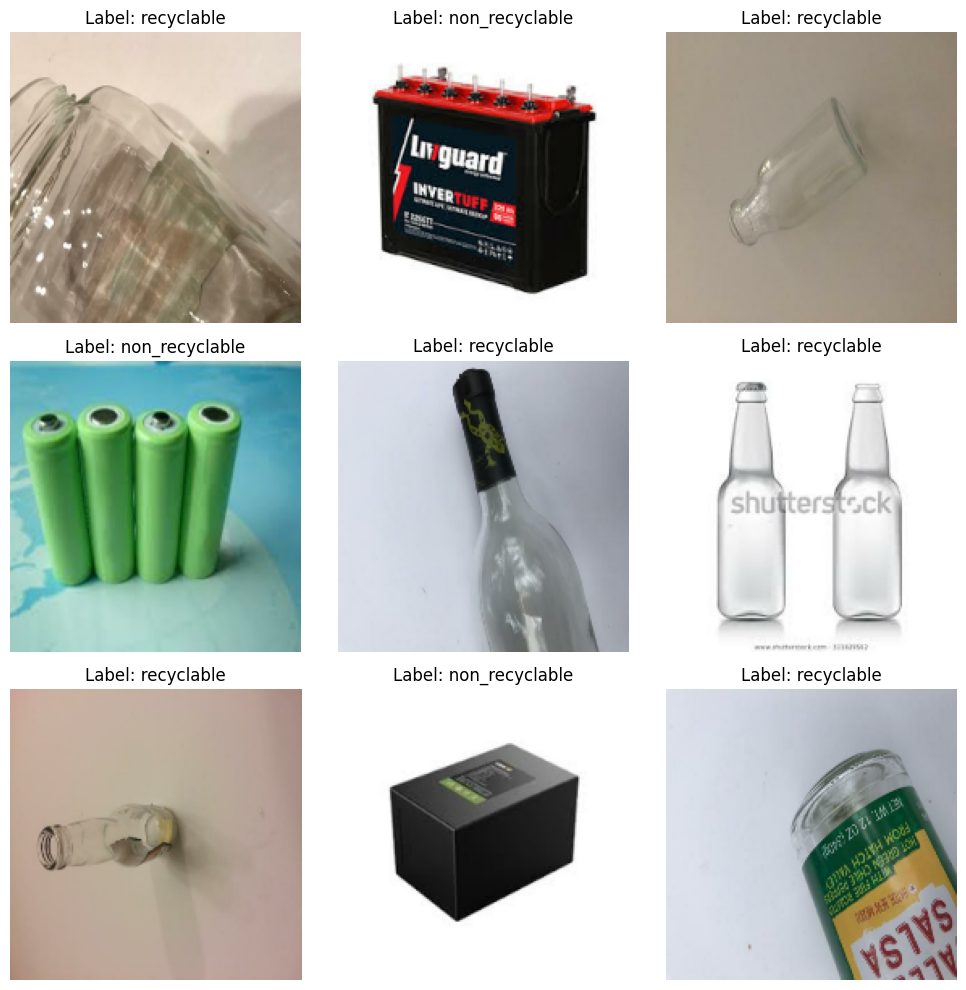

In [15]:
# Define a function to plot different sample images from the data set
def plot_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 10))

    # Consider a single batch from the dataset
    for images, labels in dataset.take(1): 
        # Loop through the first 9 images in the batch
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))                   # Display the image after converting it to the right format
            plt.title(f"Label: {class_names[int(labels[i])]}")              # Set the the title of the plot using the class name
            plt.axis("off")                                                 # Hide the axis
    plt.tight_layout()
    plt.show()                                                              # Display the plot

class_names = train_dataset.class_names                                     # Get the class names from the train dataset
plot_sample_images(train_dataset, class_names)                              # Call the function to plot the sample images from the train dataset

**Summary:** We were able to view random images of different classes from the train dataset and also including their labels.

### **Visualize the distribution for the train, validation and test dataset using barplot**

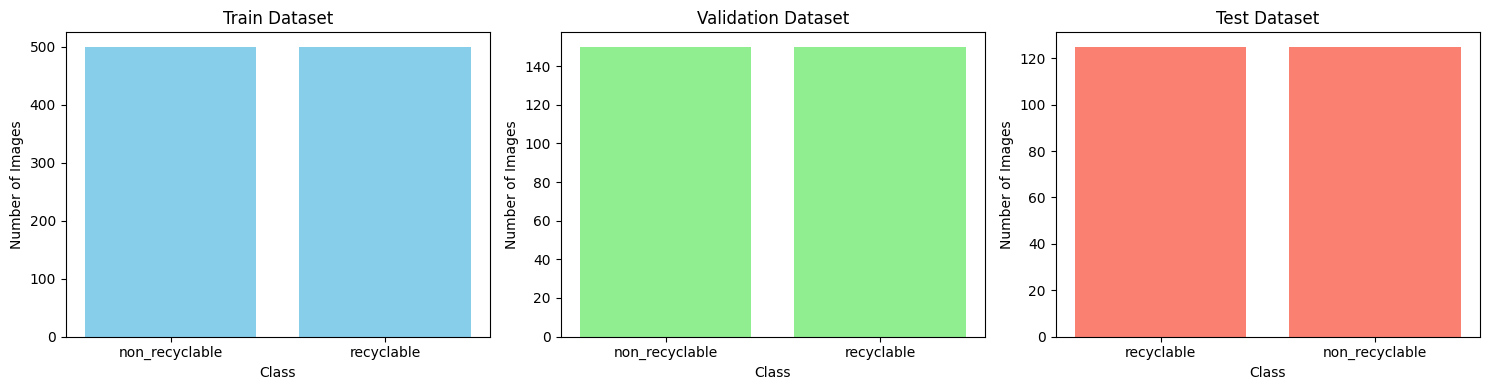

Train Label Counts: {'non_recyclable': 500, 'recyclable': 500}
Validation Label Counts: {'non_recyclable': 150, 'recyclable': 150}
Test Label Counts: {'recyclable': 125, 'non_recyclable': 125}


In [13]:
# Define a function to count the number of samples in each class
def get_label_distribution(dataset):
    label_counts = Counter()
    for _, label in dataset.unbatch():  
        label = int(label.numpy())      
        label_counts[label] += 1
    return label_counts

# Get the label distribution from each dataset
train_label_dist = get_label_distribution(train_dataset)
val_label_dist = get_label_distribution(validation_dataset)
test_label_dist = get_label_distribution(test_dataset)

# Define class names based on the dataset’s order
class_names = train_dataset.class_names  

# Extract label names and values
train_label_names = [class_names[i] for i in train_label_dist.keys()]
train_label_values = [train_label_dist[i] for i in train_label_dist.keys()]

val_label_names = [class_names[i] for i in val_label_dist.keys()]
val_label_values = [val_label_dist[i] for i in val_label_dist.keys()]

test_label_names = [class_names[i] for i in test_label_dist.keys()]
test_label_values = [test_label_dist[i] for i in test_label_dist.keys()]

# Plot the bar charts side-by-side
plt.figure(figsize=(15, 4))

# Barplot for the Train dataset
plt.subplot(1, 3, 1)
plt.bar(train_label_names, train_label_values, color='skyblue')
plt.title("Train Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")

# Barplot for the Validation dataset
plt.subplot(1, 3, 2)
plt.bar(val_label_names, val_label_values, color='lightgreen')
plt.title("Validation Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")

# Barplot for the Test dataset
plt.subplot(1, 3, 3)
plt.bar(test_label_names, test_label_values, color='salmon')
plt.title("Test Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()

# Show the label counts
print("Train Label Counts:", dict(zip(train_label_names, train_label_values)))
print("Validation Label Counts:", dict(zip(val_label_names, val_label_values)))
print("Test Label Counts:", dict(zip(test_label_names, test_label_values)))


**Explain:**
We can see from this bar chart that the training dataset is balanced between the classes(recyclable and non-recyclable) which is ideal for training a model because it will reduce the risk of the model being biased.

### **Ratio of Recyclable and Non-Recyclable in each dataset**

In [14]:
def get_label_distribution(dataset):
    label_counts = Counter()
    for _, label in dataset.unbatch():
        label_counts[int(label.numpy())] += 1
    return label_counts

print("Train label distribution:", get_label_distribution(train_dataset))
print("Validation label distribution:", get_label_distribution(validation_dataset))
print("Test label distribution:", get_label_distribution(test_dataset))

Train label distribution: Counter({0: 500, 1: 500})
Validation label distribution: Counter({1: 150, 0: 150})
Test label distribution: Counter({0: 125, 1: 125})


**Summary:** this show that each of the dataset(train, validation and test) contains a balance ratio of 0 and 1 in their dataset. 

## **Model Architectures**

### **Data Augmentation**

In [16]:
data_augmentation = keras.Sequential([

    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

#### **Visualize the augmented images**

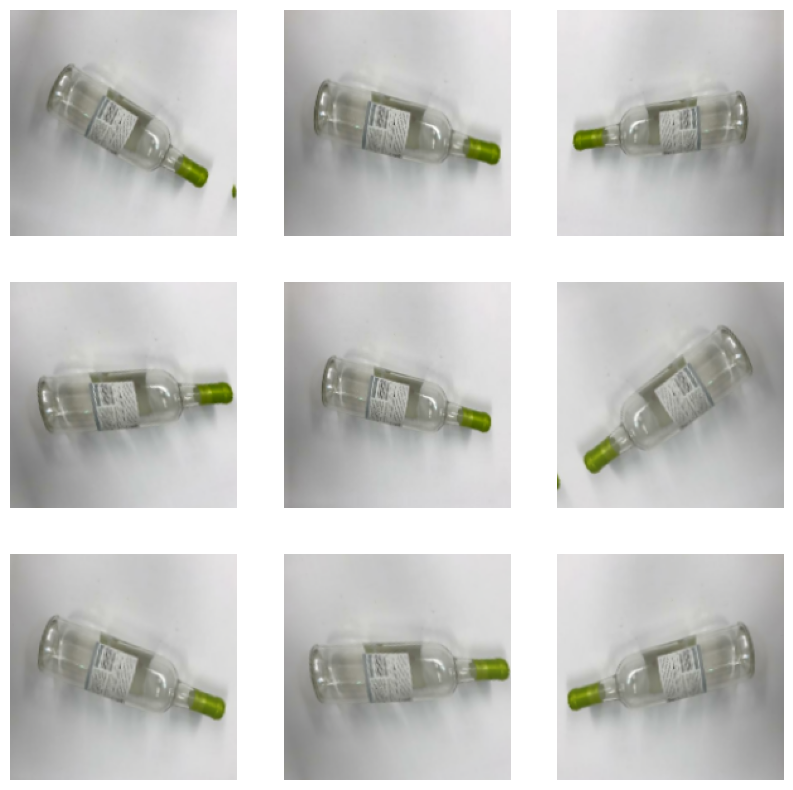

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### **Custom CNN Model**

##### Summary of the Custom CNN Model
**Layers used:**
| **Layers** | **Purpose** |
|:----------|:------------|
| Input(shape=(180, 180, 3)) | This layer accepts the 180x180 pixel images with 3 color channels (RGB) as the input to the model. |
| data_augmentation | This layer will apply the augmentation to expand the training dataset and prevent overfitting. |
| Rescaling(1./255) | This layer will normalize pixel values from [0, 255] to [0, 1] to make training more stable and faster. |
| Conv2D (4 layers) | This layer is being used to detect important patterns in images such as edges, textures, and shapes using the filters. |
| BatchNormalization (3 layers)  | This layer normalizes activations in each batch to stabilize and speed up training. It also helps the model converge faster and avoid overfitting. |
| MaxPooling2D (3 layers)  | This layer will reduce the size of feature maps (downsampling) to make the model more efficient and capture dominant features. |
| Dropout (3 layers)  | This layer contains randomly disabled neurons that are used while training the model to prevent overfitting and enhance its overall robustness. |
| Flatten | This flattening layer retrieves one-dimensional vector information which connects to Dense layers. |
| Dense(64, activation='relu') | The fully connected layer produces high-level abstract features from processed feature maps that have been flattened. |
| Dense(1, activation='sigmoid') | This outputs a single value between 0 and 1 representing the probability of the image being recyclable or not (binary classification) using the sigmoid activation. |


**Why you chose this architecture:** We are using several convolutional layers to extract hierarchical features, batch normalization and dropout for regularization, and a final sigmoid output for binary classification, the architecture was created to strike a balance between simplicity and performance.  The model may be used practically since it is lightweight and expressive enough to recognize patterns that differentiate recyclable materials from non-recyclable ones.

##### Define the Custom CNN 

In [ ]:
# Define a Neural Network
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                           

**Summary:** The model has 5,697,857 parameters in total, of which 5,697,409 are trainable and 448 are non-trainable. 

##### **Training Configuration of the Custom CNN Model**

**Using Adam optimizer**<br>
**Reason for the optimizer:** The deep learning model in this project is trained using the Adam (Adaptive Moment Estimation) optimizer because Adam combines the benefits of both the RMSProp and AdaGrad (adaptive learning rates), it is a particularly very popular and potent optimizer in deep learning.

**Reason for the Structure:**  We are using EarlyStopping here because it stops training early if the validation loss doesn’t improve, prevents overfitting and saves time then the ReduceLROnPlateau lowers the learning rate when progress stalls, helping the model fine-tune better.

In [ ]:
# Compile the CNN model
model.compile(loss="binary_crossentropy",
              optimizer= keras.optimizers.Adam(),
              metrics=["accuracy"])

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_cnn_with_adam.keras",
        save_best_only=True,
        monitor="val_loss"),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]

# Train the Custom CNN Model
history = model.fit( 
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 [==============================] - 65s 2s/step - loss: 2.2987 - accuracy: 0.8610 - val_loss: 4.0245 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 44s 1s/step - loss: 0.4697 - accuracy: 0.9340 - val_loss: 3.6152 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 49s 2s/step - loss: 0.3483 - accuracy: 0.9380 - val_loss: 4.2255 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 55s 2s/step - loss: 0.1939 - accuracy: 0.9540 - val_loss: 15.3863 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 54s 2s/step - loss: 0.1571 - accuracy: 0.9510 - val_loss: 10.0014 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 53s 2s/step - loss: 0.0671 - accuracy: 0.9810 - val_loss: 8.5525 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 7/50
32/32 [==============================] - 51s 2s/step - loss: 0.06

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.8610(approximately 86%) then increases to 0.9980 during epoch 32.<br>
The validation accuracy was maximum at epoch 36 with a value of 0.9467.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 26 with the value 0.3481.

**Using rmsprop optimizer**<br>
**Reason for the optimizer:** We used RMSprop because it helps adjust the learning rate dynamically for each parameter, which is useful when training deep neural networks. It works especially well for handling noisy datasets and can maintain a good balance between speed and stability during training.

**Reason for the Structure:** We are using EarlyStopping here because it stops training early if the validation loss doesn’t improve, prevents overfitting and saves time then the ReduceLROnPlateau lowers the learning rate when progress stalls, helping the model fine-tune better.


In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_cnn_with_rmsprop.keras",
        save_best_only=True,
        monitor="val_loss"),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 [==============================] - 71s 2s/step - loss: 1.2261 - accuracy: 0.9200 - val_loss: 0.9984 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 63s 2s/step - loss: 0.2736 - accuracy: 0.9430 - val_loss: 2.1970 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 59s 2s/step - loss: 0.3173 - accuracy: 0.9380 - val_loss: 0.8072 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 58s 2s/step - loss: 0.1682 - accuracy: 0.9590 - val_loss: 0.4732 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 58s 2s/step - loss: 0.2408 - accuracy: 0.9320 - val_loss: 1.0869 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 57s 2s/step - loss: 0.2414 - accuracy: 0.9480 - val_loss: 1.6770 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 58s 2s/step - loss: 0.1694 - a

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.9200(approximately 92%) then increases to 0.9930 during epoch 19.<br>
The validation accuracy was maximum at epoch 19 with a value of 0.9300.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 9 with the value 0.4381.

##### **Results & Evaluation for the two optimizers used for the Custom CNN Model**

**Accuracy for the two optimizers used for the Custom CNN Model**

In [23]:
# Accuracy of the CNN Model with Adam Optimizer
cnn_adam_test_model = keras.models.load_model("./models/best_cnn_with_adam.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = cnn_adam_test_model.evaluate(test_dataset)

# Display the test Accuracy 
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 2s 200ms/step - loss: 1.0059 - accuracy: 0.8920
Test accuracy: 0.892


In [30]:
# Accuracy of the CNN Model with rmsprop Optimizer
cnn_rms_test_model = keras.models.load_model("./models/best_cnn_with_rmsprop.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = cnn_rms_test_model.evaluate(test_dataset)

# Display the test Accuracy 
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 2s 213ms/step - loss: 0.9311 - accuracy: 0.8080
Test accuracy: 0.808


**Summary for the accuracy:** comparing the accuracy obtained by the Adam optimize(~89%) with the RMSprop optimizer(~81%), the Adam optimizer obtained a better accuracy.

**Training vs. validation loss and accuracy visualization for the two optimizers used for the Custom CNN Model**

Training vs. validation loss and accuracy visualization with Adam Optimizer

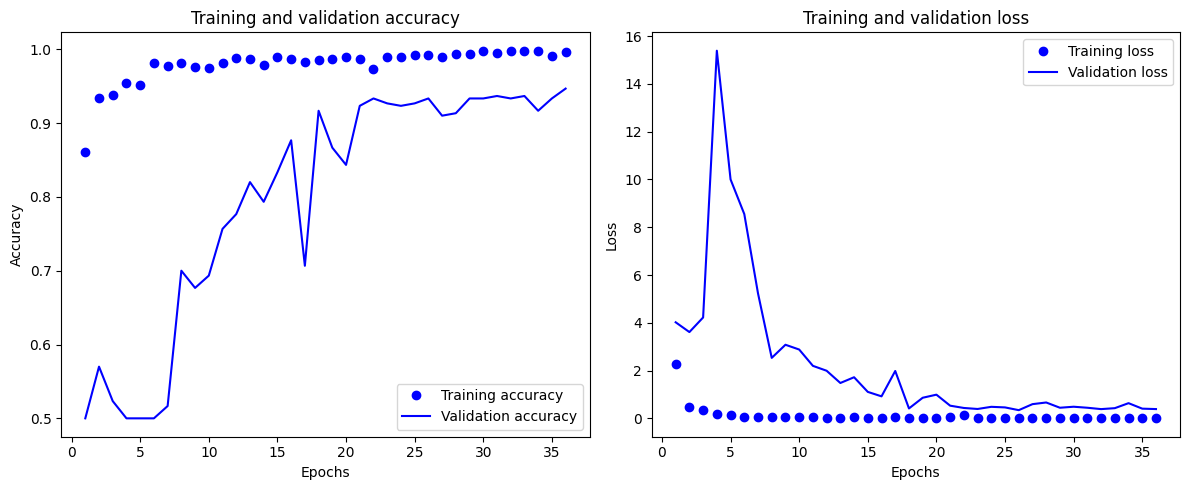

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 26 where the validation loss is the lowest.

Training vs. validation loss and accuracy visualization with rmsprop Optimizer

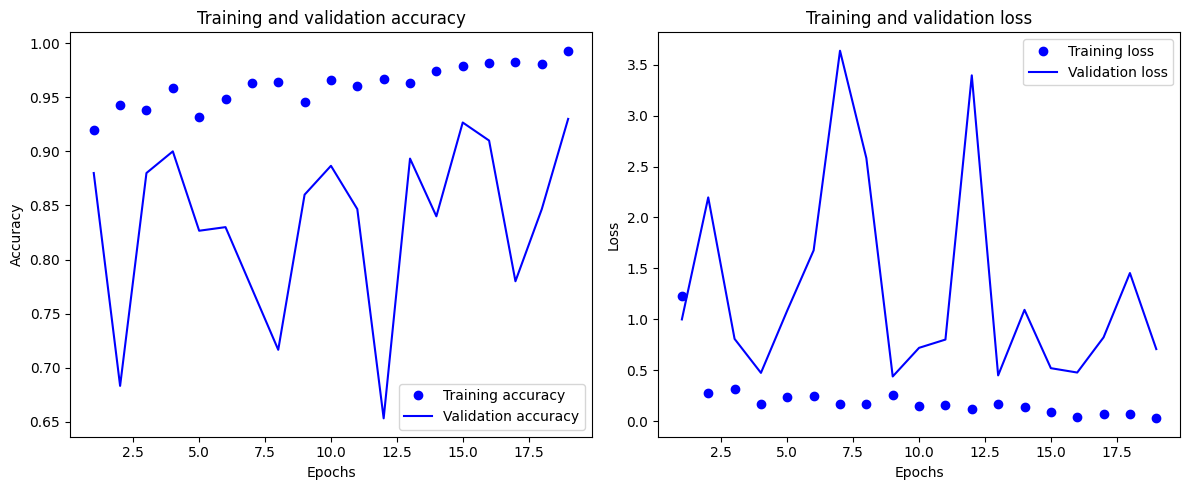

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:** Observing this visualize graph we could see that overfitting is evident, around epoch 9 where the validation loss is the lowest.

**Confusion Matrix and Classification Report for the two optimizers used for the Custom CNN Model**

Confusion Matrix and Classification Report for Adam optimizer

8/8 [==============================] - 4s 395ms/step


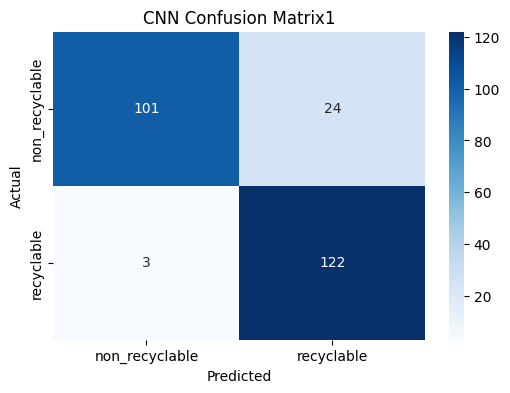

In [25]:
# Load the saved models 
cnn_adam_model  = load_model("./models/best_cnn_with_adam.keras")

# Make predictions 
cnn_adam_predictions = cnn_adam_model.predict(test_images)
cnn_adam_predictions = (cnn_adam_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
cnn_adam_cm = confusion_matrix(test_labels, cnn_adam_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_adam_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [26]:
# CNN Evaluation
print("CNN Classification Report1:")
print(classification_report(test_labels, cnn_adam_predictions, target_names=class_names))

CNN Classification Report1:
                precision    recall  f1-score   support

non_recyclable       0.97      0.81      0.88       125
    recyclable       0.84      0.98      0.90       125

      accuracy                           0.89       250
     macro avg       0.90      0.89      0.89       250
  weighted avg       0.90      0.89      0.89       250



Confusion Matrix and Classification Report for rmsprop optimizer

8/8 [==============================] - 2s 233ms/step


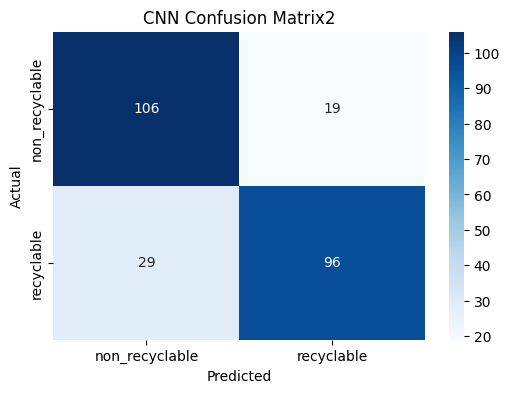

In [32]:
# Load the saved models 
cnn_rms_model  = load_model("./models/best_cnn_with_rmsprop.keras")

# Make predictions 
cnn_rms_predictions = cnn_rms_model.predict(test_images)
cnn_rms_predictions = (cnn_rms_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
cnn_rms_cm = confusion_matrix(test_labels, cnn_rms_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cnn_rms_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("CNN Confusion Matrix2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [33]:
# CNN Evaluation
print("CNN Classification Report2:")
print(classification_report(test_labels, cnn_rms_predictions, target_names=class_names))

CNN Classification Report2:
                precision    recall  f1-score   support

non_recyclable       0.79      0.85      0.82       125
    recyclable       0.83      0.77      0.80       125

      accuracy                           0.81       250
     macro avg       0.81      0.81      0.81       250
  weighted avg       0.81      0.81      0.81       250



Comparing using the Precision-Recall Curve

8/8 [==============================] - 2s 206ms/step


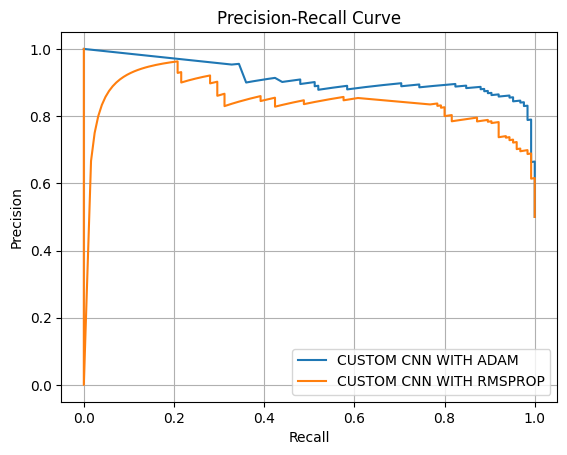

In [35]:
# Precision-Recall Curve for CUSTOM CNN WITH ADAM Model
cnn_adam_probabilities = cnn_adam_model.predict(test_images).flatten()
precision_cnn_adam, recall_cnn_adam, _ = precision_recall_curve(test_labels, cnn_adam_probabilities)
plt.plot(recall_cnn_adam, precision_cnn_adam, label="CUSTOM CNN WITH ADAM")

# Precision-Recall Curve for CUSTOM CNN WITH RMSPROP Model
cnn_rms_probabilities = cnn_rms_model.predict(test_images).flatten()
precision_cnn_rms, recall_cnn_rms, _ = precision_recall_curve(test_labels, cnn_rms_probabilities)
plt.plot(recall_cnn_rms, precision_cnn_rms, label="CUSTOM CNN WITH RMSPROP")

# Plot 
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

**Explain:** The Precision-Recall Curve also shows the Adam optimizer maintains higher precision consistently across different thresholds compared to RMSprop.

#### **Conclusion** 
The Custom CNN model trained with the Adam optimizer did better overall, with higher precision, recall, and F1-scores, while the one with RMSprop optimizer performed reasonably but had a hard time correctly predicting recyclable items, with its recall dropping to 0.77 compared to 0.98 for Adam. 

For the Custom CNN model we will be going with the one trained with the Adam Optimizer because it achieved overall best results compared with the RMSProp optimizer.

### **MobileNetV2 Model**

**MobileNetV2** was created by Google, it has small and effective convolutional neural network for embedded and mobile applications. It's inverted residual blocks and depthwise separable convolutions are used to minimize computation and model size while preserving accuracy.

**The Reason We Used It:**
The MobileNetV2 is quick, precise, and ideal for transfer learning. Its pre-trained ImageNet capabilities could enhance our project's performance in predicting recyclable from non-recyclable material.

##### **Load the MobileNetV2**

In [36]:
# Load MobileNet with pre-trained ImageNet weights
mobile_base_model = MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

# Model Summary
mobile_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

**Explain:** The MobileNetV2 model loaded uses pre-trained ImageNet weights adapted for 180x180 RGB inputs, though it was originally trained on 224x224 images. It consists of efficient depthwise separable convolution blocks that progressively reduce spatial dimensions while expanding channel depth totaling about 2.2 million trainable parameters. 

##### **Model Fine tunning**
The code below freezes MobileNetV2's layers (trainable=False), preventing their weights from updating during training, which is useful for transfer learning. Freezing preserves pre-trained features while training only the new layers added on top. 

In [39]:
# Freeze the base model
mobile_base_model.trainable = False  

# Build the model
mobile_model = models.Sequential([
    mobile_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')    
])

mobile_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,422,081
Trainable params: 164,097
Non-

**Explain:**
This summary shows a transfer learning model where MobileNetV2's 2.26M parameters are frozen(non-trainable), while only the new top layers (164k parameters) are trainable for bonary classification. 

##### **Training Configuration of the MobileNetV2 model**

**Using Adam optimizer**

In [ ]:
mobile_model.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_mobilenet_with_adam.keras",
        save_best_only=True,
        monitor="val_loss"),


    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

history = mobile_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 [==============================] - 22s 619ms/step - loss: 0.2588 - accuracy: 0.8880 - val_loss: 0.1762 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 19s 583ms/step - loss: 0.1463 - accuracy: 0.9540 - val_loss: 0.1820 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 19s 582ms/step - loss: 0.1203 - accuracy: 0.9570 - val_loss: 0.1759 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 18s 575ms/step - loss: 0.0911 - accuracy: 0.9700 - val_loss: 0.1682 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 18s 570ms/step - loss: 0.1011 - accuracy: 0.9680 - val_loss: 0.2105 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 19s 580ms/step - loss: 0.0801 - accuracy: 0.9760 - val_loss: 0.1732 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 26s 808ms/st

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.8880(approximately 89%) then increases to 0.9990 during epoch 22.<br>
The validation accuracy was maximum at epoch 22 with a value of 0.9467.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 13 with the value 0.1548.

**Using rmsprop optimizer**

In [ ]:
mobile_model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_mobilenet_with_rmsprop.keras",
        save_best_only=True,
        monitor="val_loss"),

   EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

history = mobile_model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 [==============================] - 27s 778ms/step - loss: 0.0835 - accuracy: 0.9700 - val_loss: 0.1748 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 25s 772ms/step - loss: 0.0319 - accuracy: 0.9880 - val_loss: 0.1722 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 19s 608ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 0.1920 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 18s 563ms/step - loss: 0.0434 - accuracy: 0.9880 - val_loss: 0.1958 - val_accuracy: 0.9367 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 18s 570ms/step - loss: 0.0278 - accuracy: 0.9920 - val_loss: 0.2010 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 18s 549ms/step - loss: 0.0441 - accuracy: 0.9890 - val_loss: 0.2100 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 18s 571ms/st

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.9700(approximately 97%) then increases to 0.9960 during epoch 12.<br>
The validation accuracy was maximum at epoch 10 with a value of 0.9467.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 2 with the value 0.1722.

##### **Results & Evaluation for the two optimizers used for the MobileNetV2 Model**

**Accuracy for the two optimizers used for the MobileNetV2 Model Model**

In [68]:
# Accuracy of the MobileNetV2 Model with Adam Optimizer
mobile_adam_test_model = keras.models.load_model("./models/best_mobilenet_with_adam.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = mobile_adam_test_model.evaluate(test_dataset)

# Display the test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 4s 318ms/step - loss: 0.2508 - accuracy: 0.9240
Test accuracy: 0.924


In [46]:
# Accuracy of the MobileNetV2 Model with rmsprop Optimizer
mobile_rms_test_model = keras.models.load_model("./models/best_mobilenet_with_rmsprop.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = mobile_rms_test_model.evaluate(test_dataset)

# Display the test Accuracy 
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 4s 440ms/step - loss: 0.3086 - accuracy: 0.9120
Test accuracy: 0.912


**Summary for the accuracy:** The MobileNetV2 model with Adam Optimizer achieved a higher test accuracy (92.4%) and lower loss (0.24) compared to the RMSprop version(91.2%), suggesting Adam performed slightly better for this task. This difference may stem from Adam's adaptive learning rate and momentum, which often helps converge faster and generalize better. However, both optimizers delivered strong results (>91% accuracy), oindicating the model architecture and transfer learning approach were effective overall.

**Training vs. validation loss and accuracy visualization for the two optimizers used for the MobileNetV2 Model**

Training vs. validation loss and accuracy visualization with Adam Optimizer

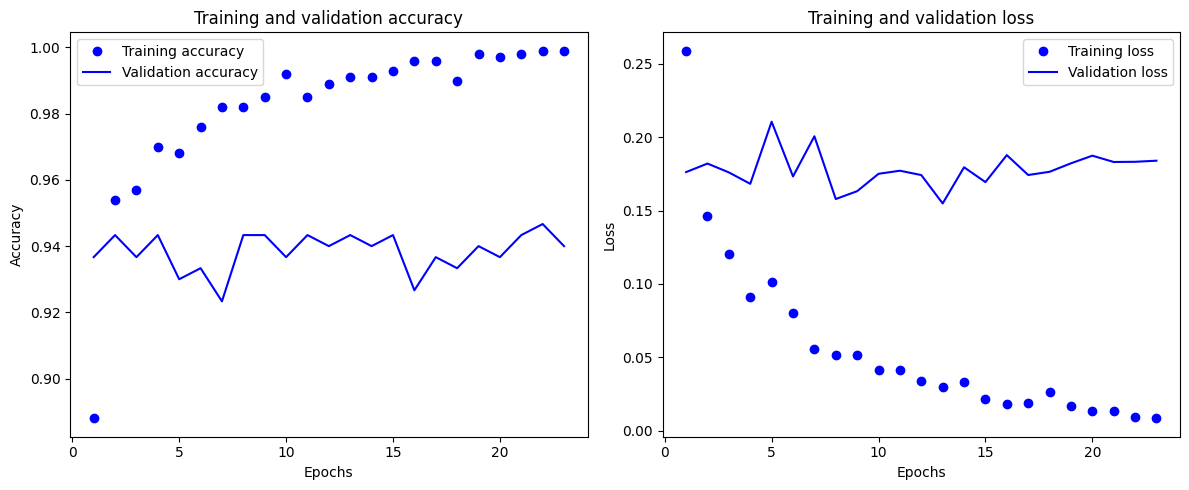

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 13 where the validation loss is the lowest.

Training vs. validation loss and accuracy visualization with rmsprop Optimizer

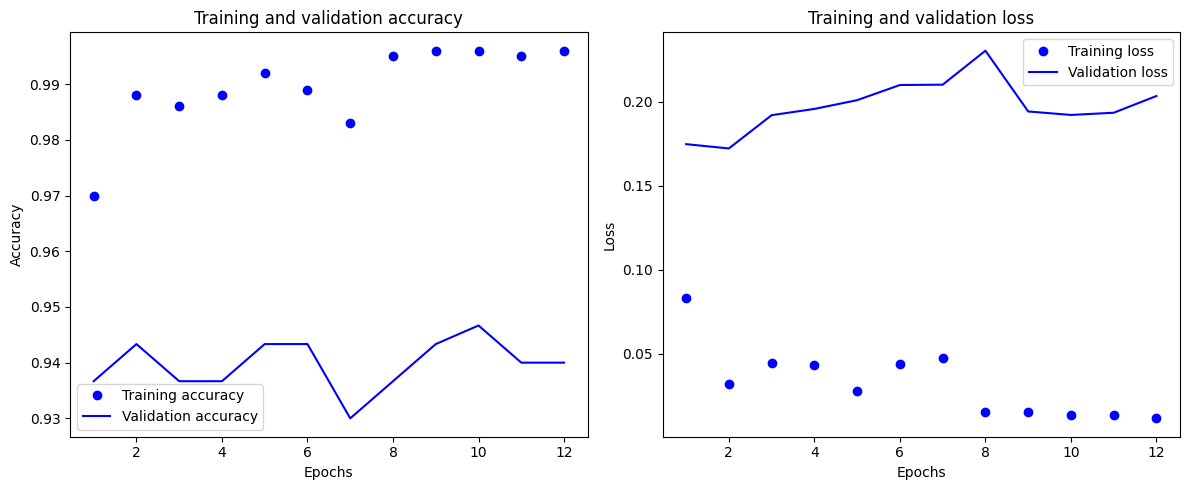

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 2 where the validation loss is the lowest.

**Confusion Matrix and Classification Report for the two optimizers used for the MobileNetV2 Model**

Confusion Matrix and Classification Report for Adam optimizer

8/8 [==============================] - 5s 618ms/step


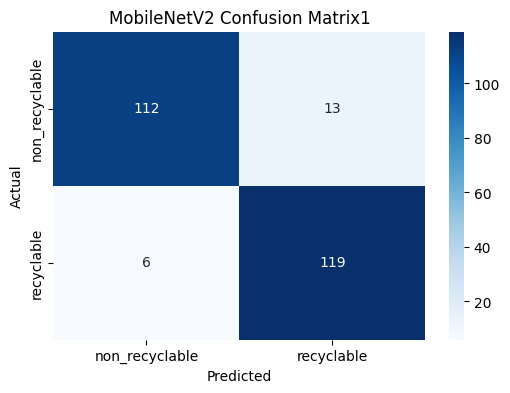

In [43]:
# Load the saved models 
mobile_adam_model  = load_model("./models/best_mobilenet_with_adam.keras")

# Make predictions 
mobile_adam_predictions = mobile_adam_model.predict(test_images)
mobile_adam_predictions = (mobile_adam_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
mobile_adam_cm = confusion_matrix(test_labels, mobile_adam_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(mobile_adam_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("MobileNetV2 Confusion Matrix1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [44]:
# CNN Evaluation
print("MobileNetV2 Classification Report1:")
print(classification_report(test_labels, mobile_adam_predictions, target_names=class_names))

MobileNetV2 Classification Report1:
                precision    recall  f1-score   support

non_recyclable       0.95      0.90      0.92       125
    recyclable       0.90      0.95      0.93       125

      accuracy                           0.92       250
     macro avg       0.93      0.92      0.92       250
  weighted avg       0.93      0.92      0.92       250



Confusion Matrix and Classification Report for rmsprop optimizer

8/8 [==============================] - 4s 367ms/step


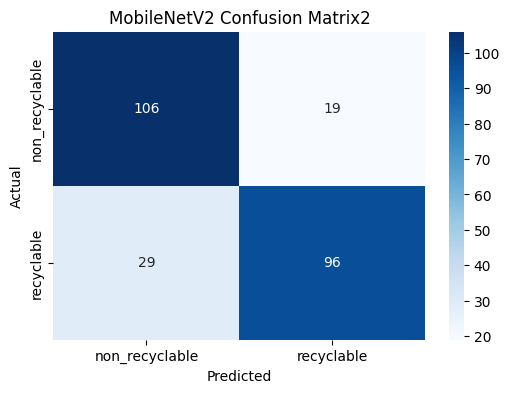

In [48]:
# Load the saved models 
mobile_rms_model  = load_model("./models/best_mobilenet_with_rmsprop.keras")

# Make predictions 
mobile_rms_predictions = mobile_rms_model.predict(test_images)
mobile_rms_predictions = (mobile_rms_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
mobile_rms_cm = confusion_matrix(test_labels, cnn_rms_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(mobile_rms_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("MobileNetV2 Confusion Matrix2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
# CNN Evaluation
print("MobileNetV2 Classification Report2:")
print(classification_report(test_labels, cnn_rms_predictions, target_names=class_names))

MobileNetV2 Classification Report2:
                precision    recall  f1-score   support

non_recyclable       0.79      0.85      0.82       125
    recyclable       0.83      0.77      0.80       125

      accuracy                           0.81       250
     macro avg       0.81      0.81      0.81       250
  weighted avg       0.81      0.81      0.81       250



Comparing using the Precision-Recall Curve

8/8 [==============================] - 4s 503ms/step


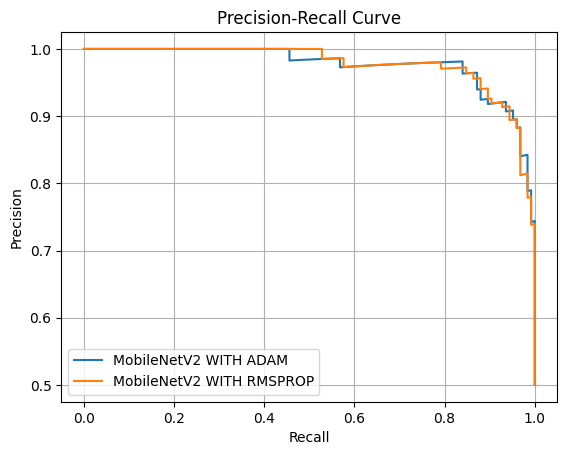

In [50]:
# Precision-Recall Curve for MobileNetV2 WITH ADAM Model
mobile_adam_probabilities = mobile_adam_model.predict(test_images).flatten()
precision_mobile_adam, recall_mobile_adam, _ = precision_recall_curve(test_labels, mobile_adam_probabilities)
plt.plot(recall_mobile_adam, precision_mobile_adam, label="MobileNetV2 WITH ADAM")

# Precision-Recall Curve for MobileNetV2 WITH RMSPROP Model
mobile_rms_probabilities = mobile_rms_model.predict(test_images).flatten()
precision_mobile_rms, recall_mobile_rms, _ = precision_recall_curve(test_labels, mobile_rms_probabilities)
plt.plot(recall_mobile_rms, precision_mobile_rms, label="MobileNetV2 WITH RMSPROP")

# Plot 
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

**Explain:** This compares the performance of MobileNetV2 models using Adam and RMSprop optimizers by plotting their precision-recall curves, which show the trade-off between correctly identifying positive cases (precision) and capturing all actual positives (recall). 

#### **Conclusion**

The comparative analysis of MobileNetV2 models with Adam and RMSprop optimizers revealed that Adam achieved slightly better performance (92.4% test accuracy vs. 91.2%) and lower loss (0.24), suggesting its adaptive learning rate was more effective for this task. The precision-recall curves provided further insights into their classification trade-offs, while training/validation plots confirmed stable learning without severe overfitting.

### **ResNet152 Model**

**ResNet152** is a deep convolutional neural network With 152 layers, constructed with **residual blocks** that permit gradients to flow through shortcut connections, which help resolve the vanishing gradient issue and facilitate the training of very deep networks, making ResNet152 an excellent choice for challenging image classification tasks.

**The Reason We Used It:** 
We chose ResNet152 for its strong ability to learn deep and detailed features, which is essential in our project for accurately distinguishing between recyclable and non-recyclable waste.  Its pretrained weights on ImageNet could also help improve performance through transfer learning.

#### **Load the ResNet152**

In [51]:
# Load ResNet152 with pre-trained ImageNet weights
res_base_Model = ResNet152(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

# Model Summary
res_base_Model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']     

**Explain:** This summary shows a ResNet152 model adapted for 180x180 RGB imputs, featuring 58.3 million total parameters with 58.2 million total trainable and 151k frozen (batch normalization layers). The architecture begins with convolutional and pooling layers, followed by stacked residual blocks that maintain spatial dimensions through identity shortcuts while prograssively extracting deeper features.

#### **Model Fine tunning**

In [ ]:
 # freeze all layers
res_base_Model.trainable = False 

# Fine Tuning
x = layers.GlobalAveragePooling2D()(res_base_Model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)  

# Build the model
res_model = models.Model(inputs=res_base_Model.input, outputs=x)

res_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']       

**Explain:** This model processes 180x180 RGB images through initial conv/pooling layers (output:45x45x64) followed by residual blocks, with batchnorm layers contributing to the frozen parameters. This setup is typical when using a pretrained ResNet as a feature extractor for a new task.

#### **Training Configuration of the ResNet152 Model**

**Using Adam optimizer**

In [ ]:
res_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_resnet_with_adam.keras",
        save_best_only=True,
        monitor="val_loss"),

    EarlyStopping(
        monitor='val_loss',
        patience= 10,
        restore_best_weights=True
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]


history = res_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
32/32 [==============================] - 207s 6s/step - loss: 0.2135 - accuracy: 0.9100 - val_loss: 0.0839 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 178s 6s/step - loss: 0.0321 - accuracy: 0.9860 - val_loss: 0.0169 - val_accuracy: 0.9867 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 186s 6s/step - loss: 0.0136 - accuracy: 0.9960 - val_loss: 0.0067 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 175s 5s/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 176s 6s/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0065 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 172s 5s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 167s 5s/step - loss: 0.0

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.9100(approximately 91%) then increases to 1 during epoch 10.<br>
The validation accuracy was maximum at epoch 3 with a value of 1.0000.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 5 with the value 0.0065.

**Using rmsprop optimizer**

In [ ]:
res_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define callbacks including Early stoping and ReduceLRonPlateau to enhance the training of the model
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/best_resnet_with_rmsprop.keras",
        save_best_only=True,
        monitor="val_loss"),

    EarlyStopping(
        monitor='val_loss',
        patience= 10,
        restore_best_weights=True
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]


history = res_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
32/32 [==============================] - 409s 13s/step - loss: 0.0207 - accuracy: 0.9930 - val_loss: 0.0161 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 385s 12s/step - loss: 0.0091 - accuracy: 0.9960 - val_loss: 0.0223 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 398s 13s/step - loss: 0.0050 - accuracy: 0.9970 - val_loss: 0.0053 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 391s 12s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 394s 12s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0196 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 348s 11s/step - loss: 0.0104 - accuracy: 0.9940 - val_loss: 0.0772 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 211s 7s/step - los

**Explain** <br>
Observing the result:<br>
The training accuracy rate starts with 0.9930(approximately 99%) then increases to 1.0000 during epoch 4.<br>
The validation accuracy was maximum at epoch 3 with a value of 0.9967.<br>
The training loss was fluctuating with epoch throughout.<br>
The validation loss was lowest at epoch 3 with the value 0.0053.

#### **Results & Evaluation for the two optimizers used for the ResNet152 Model Model**

**Accuracy for the two optimizers used for the ResNet152 ModelModel**

In [55]:
# Accuracy of the ResNet152 Model with Adam Optimizer
res_adam_test_model = keras.models.load_model("./models/best_resnet_with_adam.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = res_adam_test_model.evaluate(test_dataset)

# Display the test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 30s 4s/step - loss: 0.0309 - accuracy: 0.9960
Test accuracy: 0.996


In [62]:
# Accuracy of the ResNet152 Model Model with rmsprop Optimizer
res_rms_test_model = keras.models.load_model("./models/best_resnet_with_rmsprop.keras")

# Evaluate the Test Accuracy
test_loss, test_acc = res_rms_test_model.evaluate(test_dataset)

# Display the test Accuracy
print(f"Test accuracy: {test_acc:.3f}")

8/8 [==============================] - 40s 5s/step - loss: 0.0256 - accuracy: 0.9960
Test accuracy: 0.996


**Summary for the accuracy:** The ResNet152 model demonstrated exceptional performance, achieving 99.6% test accuracy with both Adam and RMSprop optimizers, significantly outperforming MobileNetV2 (92.4%) and custom CNN (89.2%) models. The near perfect accuracy, stable validation metrics and minimal loss confirm ResNet152's superiority for this recyclable/non-recyclable image classification problem.

**Training vs. validation loss and accuracy visualization for the two optimizers used for the Custom CNN Model**

Training vs. validation loss and accuracy visualization with Adam Optimizer

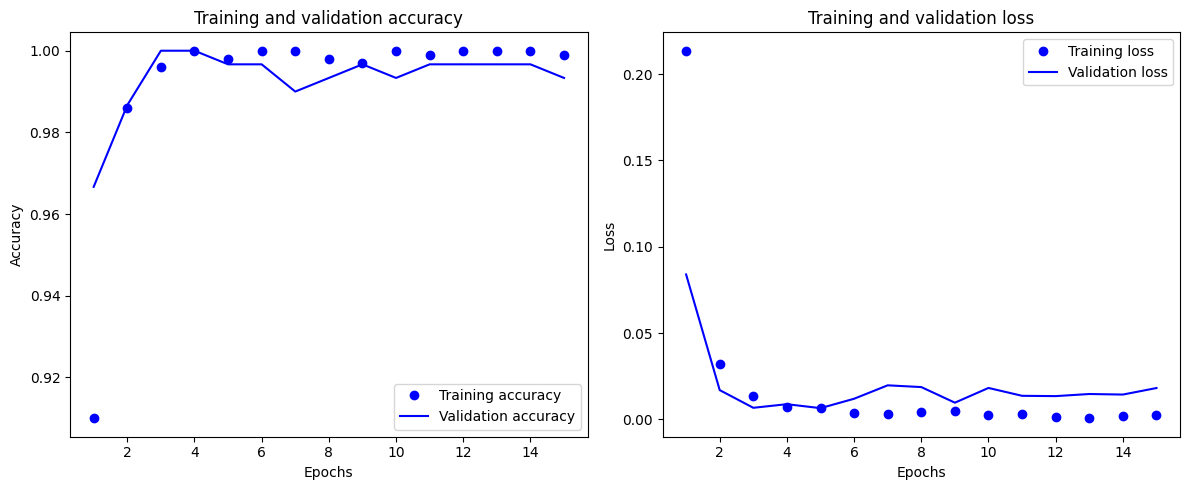

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 5 where the validation loss is the lowest.

Training vs. validation loss and accuracy visualization with rmsprop Optimizer

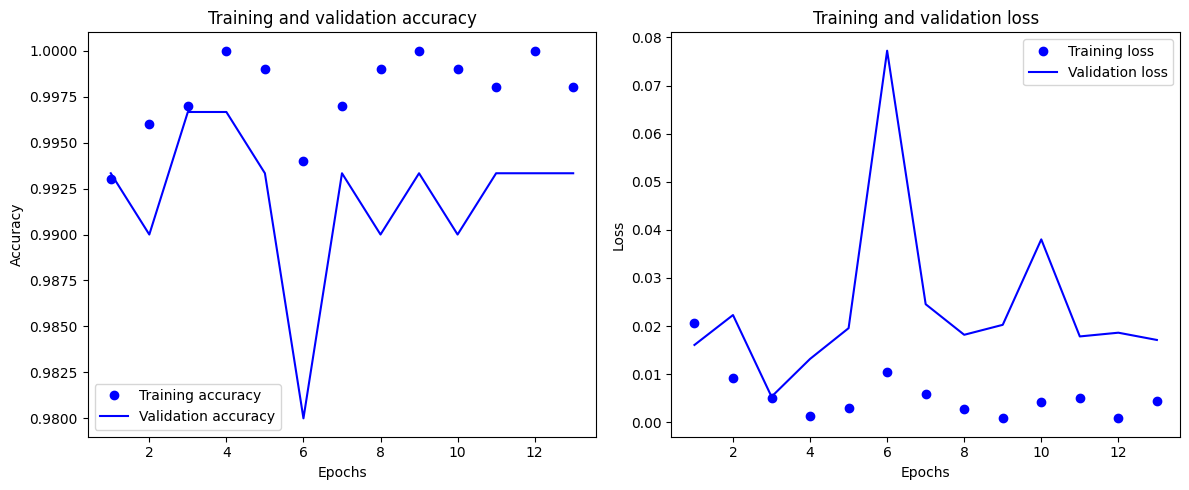

In [ ]:
# Extract the metrics from the history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

# figure size for the subplots
plt.figure(figsize=(12, 5))

# Plot the Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Explain:**
Observing this visualize graph we could see that overfitting is evident, around epoch 3 where the validation loss is the lowest.

**Confusion Matrix and Classification Report for the two optimizers used for the Custom CNN Model**

Confusion Matrix and Classification Report for Adam optimizer

8/8 [==============================] - 33s 4s/step


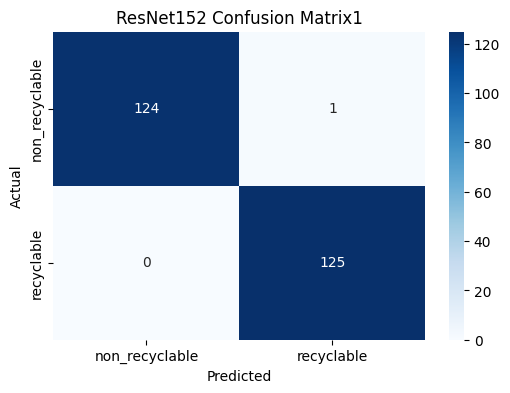

In [57]:
# Load the saved models 
res_adam_model  = load_model("./models/best_resnet_with_adam.keras")

# Make predictions 
res_adam_predictions = res_adam_model.predict(test_images)
res_adam_predictions = (res_adam_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
res_adam_cm = confusion_matrix(test_labels, res_adam_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(res_adam_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("ResNet152 Confusion Matrix1")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [58]:
# ResNet152 Evaluation
print("ResNet152 Classification Report1:")
print(classification_report(test_labels, res_adam_predictions, target_names=class_names))

ResNet152 Classification Report1:
                precision    recall  f1-score   support

non_recyclable       1.00      0.99      1.00       125
    recyclable       0.99      1.00      1.00       125

      accuracy                           1.00       250
     macro avg       1.00      1.00      1.00       250
  weighted avg       1.00      1.00      1.00       250



Confusion Matrix and Classification Report for rmsprop optimizer

8/8 [==============================] - 26s 3s/step


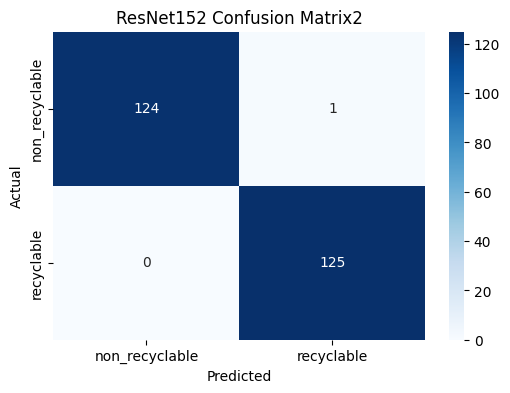

In [16]:
# Load the saved models 
res_rms_model  = load_model("./models/best_resnet_with_rmsprop.keras")

# Make predictions 
res_rms_predictions = res_rms_model.predict(test_images)
res_rms_predictions = (res_rms_predictions > 0.5).astype("int32").flatten()

# Plot the confusion matrix
res_rms_cm = confusion_matrix(test_labels, res_rms_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(res_rms_cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("ResNet152 Confusion Matrix2")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
# ResNet152 Evaluation
print("ResNet152 Classification Report2:")
print(classification_report(test_labels, res_rms_predictions, target_names=class_names))

ResNet152 Classification Report2:
                precision    recall  f1-score   support

non_recyclable       1.00      0.99      1.00       125
    recyclable       0.99      1.00      1.00       125

      accuracy                           1.00       250
     macro avg       1.00      1.00      1.00       250
  weighted avg       1.00      1.00      1.00       250



Comparing using the Precision-Recall Curve

8/8 [==============================] - 38s 5s/step


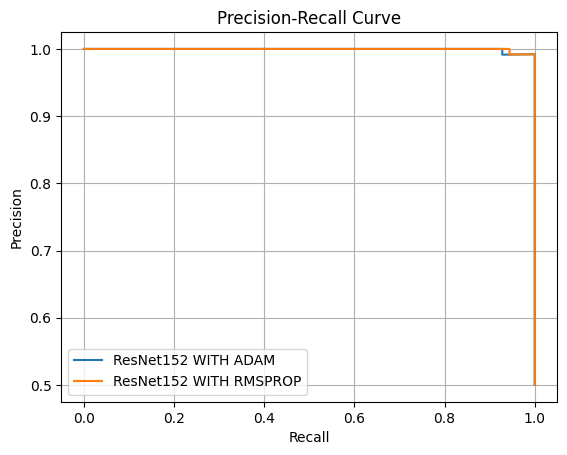

In [67]:
# Precision-Recall Curve for ResNet152 WITH ADAM Model
res_adam_probabilities = res_adam_model.predict(test_images).flatten()
precision_res_adam, recall_res_adam, _ = precision_recall_curve(test_labels, res_adam_probabilities)
plt.plot(recall_res_adam, precision_res_adam, label="ResNet152 WITH ADAM")

# Precision-Recall Curve for ResNet152 WITH RMSPROP Model
res_rms_probabilities = res_rms_model.predict(test_images).flatten()
precision_res_rms, recall_res_rms, _ = precision_recall_curve(test_labels, res_rms_probabilities)
plt.plot(recall_res_rms, precision_res_rms, label="ResNet152 WITH RMSPROP")

# Plot 
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.show()

**Explain:** The precision-recall curves for ResNet152 models using Adam and RMSprop optimizers, showing the trade-off between correctly identifying positive cases (precision) and capturing all actual positives (recall). 

#### **Conclusion**
 The ResNet152 model demonstrated exceptional performance, achieving 99.6% test accuracy with both Adam and RMSprop optimizers. The training plots showed ideal convergence with no overfitting and classification reports confirmed robust F1 scores for both recyclable and non-recyclable classes. This makes ResNet152 the top-performing model for this binary classification task, though its computational cost may warrant considering lighter models like MobileNetV2 if marginal accuracy gains don't justify resource needs.

## **Final Conclusion**

We succesfully implemented an image classification system aimed at distinguishing between Recyclable and Non-Recyclabe waste materials. This classification plays a significant role in promoting sustainable waste management practices by automating the sorting process and reducing human error. To achieve this, we leveraged the power of transfer learning by using well-established pre-trained models such as CNN (Convolutional Neural Networks), MobileNetV2, and ResNet152. These models are trained on large image datasets and offer strong feature extraction capabilities which significantly boosted the performance of our classifier without the need to train a model efficiency but reduced computational cost and training time.

Our workflow began with thorough data preparation, including loading and organizing a real-world image dataset obtained from Kaggle. We performed image preprocessing techniques such as resizing, normalization and data augmentation to ensure model generalization and reduce overfitting.

The models were trained using Tensorflow and Keras frameworks, and we used performance optimization strategies such as: EarlyStopping to prevent overfitting, ReduceLROnPlateau to adjust learning rates dynamically, And appropriate batch sizing and epoch management to strike a balance between training time and performance. 

We evaluated our models using a range of metrics such as accuracy, confusion matrices and classification reports to guage how well the models performed on unseen data. Visualization tools, including loss/accuracy curves were also used to monitor training behavior over time.

Among the models tested, ResNet152 showed excellent classification performance, making them suitable candidates for real-time waste sorting systems. Our best performing model achieved high accuracy in distinguishing waste types, demonstrating the system's potential for deployment in smart cities or recycling facilities.

In conclusion, this project reflects a strong understanding of modern machine learning techniques, particurlaly in:
- Applying pre-trained deep learning architectures effectively
- Handling image-based datasets in real-world scenerios
- Implementing techniques to prevent model overfitting
- And conducting rigorous performance evaluation

Going forward, this model could be further improved and extended to handle more waste categories (e.g recyclable plastics, hazardous materials) and integrated into a mobile or embedded system for real-time usage in urban and industrial environments.